In [53]:
# Check pytorch version
import torch

print(torch.__version__)

2.5.1


In [54]:
!nvidia-smi

Sun Dec  1 21:01:04 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.59                 Driver Version: 556.13         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...    On  |   00000000:01:00.0  On |                  N/A |
| N/A   44C    P8              5W /   89W |    2686MiB /   8188MiB |     28%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [55]:
print("Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")

Device Name: NVIDIA GeForce RTX 4060 Laptop GPU


In [56]:
# Use GPU for training
device = torch.device("cuda")

In [57]:
# Import necessary packages
import torch.nn as nn
import torch.optim 
from torch.utils.data import DataLoader, Dataset, Subset

import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

In [58]:
# Fix random seed for reproducibility
seed = 77
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# Avoid nondeterministic algorithms and disable benchmarks for convolution operations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [59]:
from torchvision import transforms, models

# Pipeline for preprocessing of the image. 
transform = transforms.Compose([

    # Convert a tensor or an ndarray to PIL Image
    # Original array is H x W x C
    # 3 channel, default mode is RGB
    transforms.ToPILImage(),

    # Resize into a fixed size same as ImageNet dataset
    transforms.Resize((224, 224)),

    # Flip the image horizontally using the default probability 0.5
    transforms.RandomHorizontalFlip(),

    # Transform to pytorch tensor
    transforms.ToTensor(),

    # Normalizes the pixel values using mean and std of the ImageNet dataset
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



In [60]:
# Check the name of keys
with h5py.File('train_catvnoncat.h5', "r") as h5_file:
    print("Keys in the file:", list(h5_file.keys()))

Keys in the file: ['list_classes', 'train_set_x', 'train_set_y']


In [61]:
# Define dataset for cat images
class cat_dataset(Dataset):
    
    def __init__(self, h5_file_path):
        self.file = h5_file_path

        with h5py.File(h5_file_path, "r") as h5_file:
          
            self.image = h5_file['train_set_x'][()]
            self.label = h5_file['train_set_y'][()]

                
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index):

        image = self.image[index]
        image = transform(image) # Preprocessing
        label = self.label[index]

        return image, label

Train dataset has 209 samples.


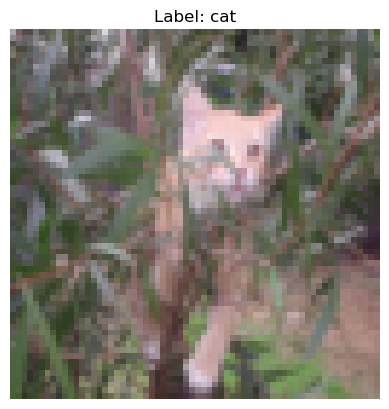

In [62]:
all_dataset = cat_dataset('train_catvnoncat.h5')

print(f'Train dataset has {len(all_dataset)} samples.')

# Viualization of the first image
check_index = 185
image = all_dataset.image[check_index]
label = all_dataset.label[check_index]
plt.imshow(image)
plt.title(f"Label: {'non-cat' if label==0 else 'cat'}")
plt.axis("off")
plt.show()

In [63]:
# Load train and test dataset
train_len = 7 + 160

train_dataset = Subset(all_dataset, range(0, train_len))
test_dataset = Subset(all_dataset, range(train_len, len(all_dataset)))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [64]:
# Load pretrained model. 
# ResNet from https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18
model = models.resnet18(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 1)  # Binary classification (1 output)

/home/patchouli/miniconda3/envs/cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/patchouli/miniconda3/envs/cuda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [65]:
''' Set hyperparameters '''

# Use Binary Cross Entropy With Logits Loss for binary classification
criterion = nn.BCEWithLogitsLoss()  
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
# Set scheduler to adjust learning rate during training
# StepLR reduce the learning rate by gamma after step_size of epoches
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1e-6)

model = model.to(device)

''' Start Training '''

num_epochs = 5
for epoch in range(num_epochs):

    # Turn to training mode
    model.train()
    train_loss = []
    train_accs = []

    for inputs, labels in train_loader:

        # The original label is 1d, so have to unsqueeze to shape (n, 1)
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)

        # Clear gradient buffers
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Get predictions after logistic function
        preds = torch.sigmoid(outputs) > 0.5
        # Compute loss and accurancy
        train_loss.append(loss.item())
        acc = (preds.float() == labels).float().mean()
        train_accs.append(acc)
    
    scheduler.step()
    epoch_loss = sum(train_loss) / len(train_loss)
    epoch_acc = sum(train_accs) / len(train_accs)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accurancy: {epoch_acc:.4f}")


Epoch 1/5, Loss: 0.5764, Accurancy: 0.7443
Epoch 2/5, Loss: 0.4093, Accurancy: 0.9318
Epoch 3/5, Loss: 0.3204, Accurancy: 0.9659
Epoch 4/5, Loss: 0.2442, Accurancy: 0.9886
Epoch 5/5, Loss: 0.2044, Accurancy: 0.9870


In [66]:
# Turn to evaluation mode
model.eval()
test_labels = []
test_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        # Convert logits to probabilities
        preds = torch.sigmoid(outputs) > 0.5  
        test_labels.extend(labels.cpu().numpy())
        test_preds.extend(preds)

print(test_labels)
test_preds = [int(x) for x in test_preds]
print(test_preds)

xnor = [ 1 if (test_preds[i] == test_labels[i]) else 0 for i in range(len(test_preds)) ]
test_acc = sum(xnor) / len(xnor)
print(f"Test accurancy: {test_acc:.4f}")

[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Test accurancy: 0.9524


Misclassification index: [185, 197]


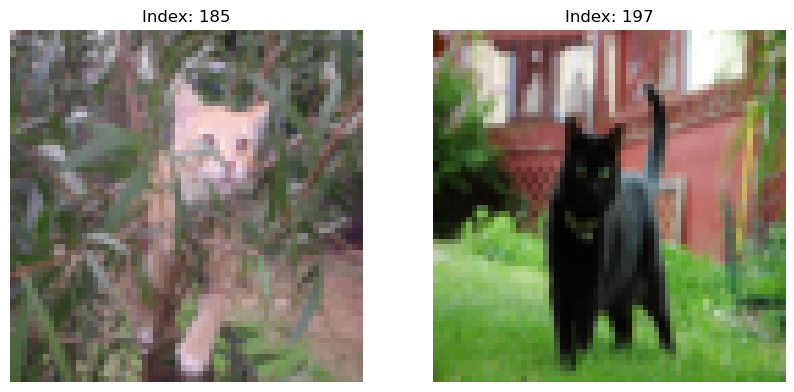

In [67]:
misclassification = {'index':[], 'image':[]}

for i in range(len(test_labels)):

    if test_preds[i] != test_labels[i]:
        misclassification['index'].append(i + train_len)
        misclassification['image'].append(all_dataset.image[i + train_len])

if misclassification != {}:

    print("Misclassification index:", misclassification['index'])
    fig, axes = plt.subplots(1, len(misclassification['index']), figsize=(5*len(misclassification['index']), 5))

    if len(misclassification['index']) == 1:
        axes = [axes]
        
    for i, ax in enumerate(axes):
        image = misclassification['image'][i]

        ax.imshow(image)
        ax.axis("off")
        ax.set_title(f"Index: {misclassification['index'][i]}")

    plt.show()
    
else:
    print('No misclassification')